In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer, AutoModel
import datasets

from utils import *
from mcpt.contrastlearning import TrainerA

In [2]:
#model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
N_EPOCHS = 1000
HEAD_BATCH_SIZE = 50
HEAD_LR = 1e-3
HEAD_GAMMA = 1.
N_CLASSES = 14

In [3]:
lang = 'fr'
train_dataset = get_dataset(f'data/{lang}')
test_dataset = get_dataset(f'data/{lang}', prefix='dev')

Dataset text downloaded and prepared to /home/alex/.cache/huggingface/datasets/text/default-0c5d9974ec534b1a/0.0.0/acc32f2f2ef863c93c2f30c52f7df6cc9053a1c2230b8d7da0d210404683ca08. Subsequent calls will reuse this data.
Dataset text downloaded and prepared to /home/alex/.cache/huggingface/datasets/text/default-c1e41b278bbf7bff/0.0.0/acc32f2f2ef863c93c2f30c52f7df6cc9053a1c2230b8d7da0d210404683ca08. Subsequent calls will reuse this data.


In [4]:
train_dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 158
})

In [5]:
test_dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 53
})

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
train_encodings = tokenizer(train_dataset['text'], padding=True, truncation=True, return_tensors='pt')
train_dataset_encoded = datasets.Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(train_dataset['labels'], dtype=torch.float32),
}).with_format('torch')

In [8]:
test_encodings = tokenizer(test_dataset['text'], padding=True, truncation=True, return_tensors='pt')
test_dataset_encoded = datasets.Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(test_dataset['labels'], dtype=torch.float32),
}).with_format('torch')

# Training

In [9]:
model = AutoModel.from_pretrained(model_name)
head = nn.Sequential(
    nn.Linear(384, 256),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(256, N_CLASSES),
    nn.Dropout(),
)
trainer = TrainerA(
    model=model,
    head=head,
    device='cpu',
    head_loss=nn.BCEWithLogitsLoss(),
    model_loss=None,
    model_dataset=None,
    head_dataset=train_dataset_encoded,
    eval_dataset=test_dataset_encoded,        
    n_classes=N_CLASSES,
    model_loader_type=None,
    train_head_batch_size=HEAD_BATCH_SIZE,
    head_lr=HEAD_LR,
    head_gamma=HEAD_GAMMA,
    validate_every_n_epochs=1,
)
trainer.train_head(N_EPOCHS)

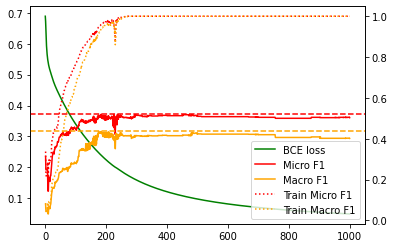

MicroF1:  0.5197368264198303  @  183
MacroF1:  0.4357164204120636  @  174
MacroF1:  0.4345884919166565  @  183


In [10]:
TrainerA.plot_metrics(trainer.log_dict, 1)